# Preparation

## Imports & functions definition

In [1]:
repo_path <- ".."

In [2]:
# Required packages
library("data.table")
library("DALEX")
library("DALEXtra")
library("ggplot2")
library("gridExtra")
library("pipeR")

# Jupyter settings
options(repr.plot.width = 22)
options(repr.plot.height = 8)
options(jupyter.rich_display = FALSE)
options(width = 120)

# Paths within the repo
data_path <- file.path(repo_path, "data/survival-data-split")
model_path <- file.path(repo_path, "models/pickles/opt_XGBTRegressor.pickle")

Welcome to DALEX (version: 1.2.0).
Find examples and detailed introduction at: https://pbiecek.github.io/ema/


Anaconda not found on your computer. Conda related functionality such as create_env.R and condaenv and yml parameters from explain_scikitlearn will not be available



In [3]:
# Function reads split data into a list.
read_data <- function(data_dir, extract_treatment = FALSE, ...) {
    data_names <- c("X_test", "X_train","y_test", "y_train")
    file_names <- sprintf("survival_%s.csv", data_names)
    paths <- file.path(data_dir, file_names)
    
    res <- setNames(lapply(paths, fread), data_names)
    if (!extract_treatment) return(res)
    
    extract_treatment(res, ...)
}


# Function separates treatment from the Xes.
extract_treatment <- function(data, idx = ncol(data$X_train)) {
    data <- lapply(data, as.data.frame)
    
    data$treatment_train <- data$X_train[, idx]
    data$X_train <- data$X_train[, -idx]
    
    data$treatment_test <- data$X_test[, idx]
    data$X_test <- data$X_test[, -idx]
    
    lapply(data, as.data.table)
}


# Function adjusts font size and fixes plot title for the DALEX plots to look cleanly in Jupyter Notebook.
fix_plot <- function(g, adjust_title_margin = FALSE, plot_title = NULL, font_size = 20) {
    g <- g + theme(
        axis.text = element_text(size = font_size),
        axis.title = element_text(size = font_size + 3),
        strip.text = element_text(size = font_size - 3, margin = margin(0, 0, 5, 0)),
        plot.subtitle = element_text(size = font_size - 2, margin = margin(-10, 0, 15, 0)),
        plot.title = element_text(size = font_size + 1),
        legend.title = element_text(size = font_size - 3),
        legend.text = element_text(size = font_size - 5)
    )
    
    if (adjust_title_margin) {
        g <- g + theme(plot.subtitle = element_text(margin = margin(0, 0, 5, 0)))
    }
    
    if (!is.null(plot_title)) {
        g <- g + ggtitle(plot_title)
    }
    
    g
}

## Reading the data

In [4]:
data <- read_data(data_path, TRUE)
X <- list(data$X_train, data$X_test) %>>% rbindlist() %>>% as.data.frame()
y <- list(data$y_train, data$y_test) %>>% rbindlist() %>>% as.data.frame()

## Creating explainers (one for each treatment variant)

In [5]:
explainer_Lev <- explain_scikitlearn(
    model_path,
    data = X,
    y = y,
    label = "XGBTRegressor Lev",
    predict_function = function(model, data, ...) yhat(model, data)[, 1],
    verbose = FALSE
)

explainer_Lev5FU <- explain_scikitlearn(
    model_path,
    data = X,
    y = y,
    label = "XGBTRegressor Lev+5FU",
    predict_function = function(model, data, ...) yhat(model, data)[, 2],
    verbose = FALSE
)

# Explainations

### Variable Importance

In [6]:
vi_Lev <- variable_importance(explainer_Lev, loss_function = loss_root_mean_square)
vi_Lev5FU <- variable_importance(explainer_Lev5FU, loss_function = loss_root_mean_square)

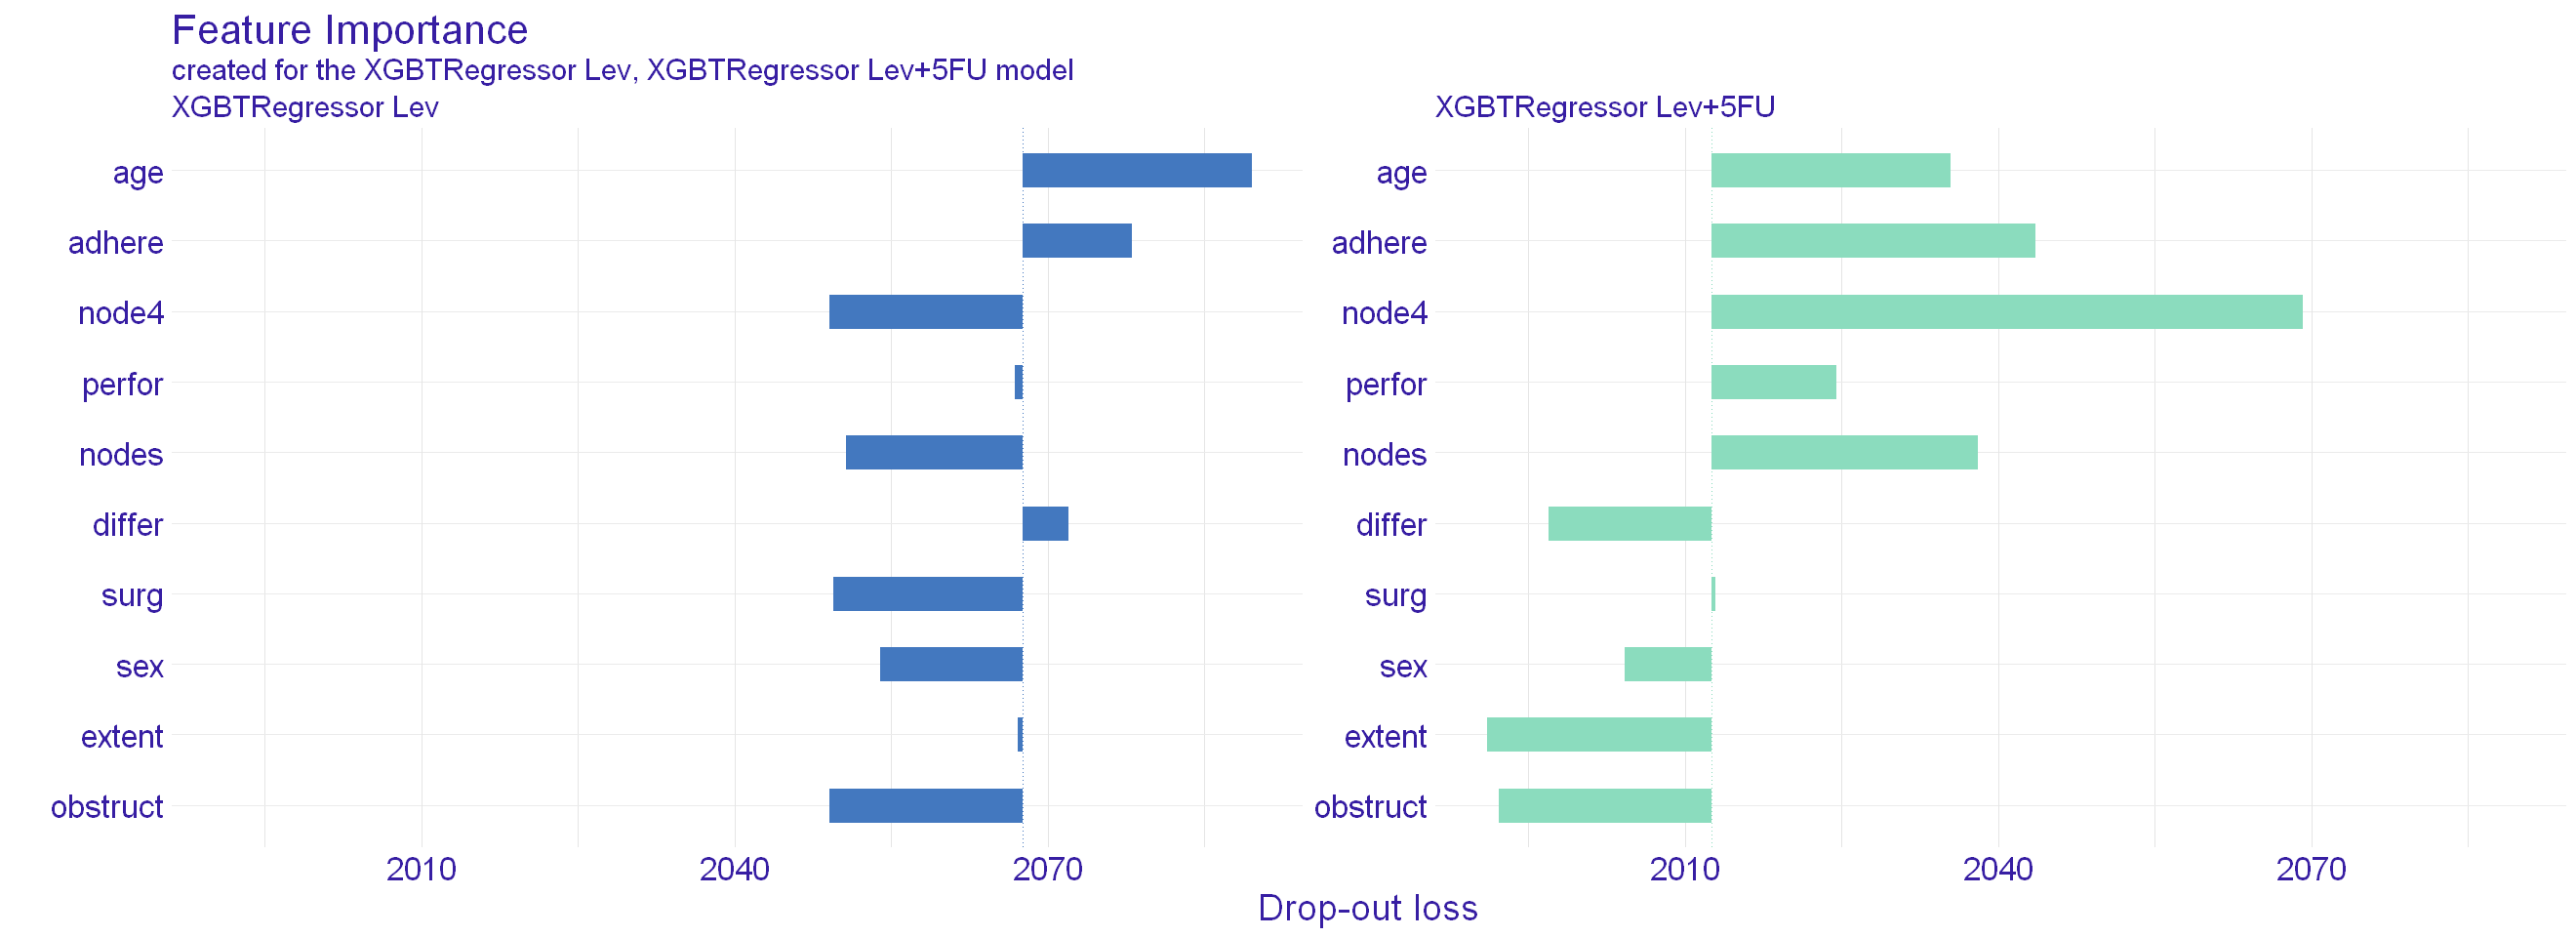

In [7]:
plot_vi <- fix_plot(
    plot(vi_Lev, vi_Lev5FU, show_boxplots = FALSE) + facet_wrap(~label, ncol = 2, scales = "free_y"),
    adjust_title_margin = TRUE
) + theme(
    strip.text = element_text(size = 18),
    plot.title = element_text(
        size = 25,
        margin = margin(0, 0, 4, 0)
    )
)

plot_vi

In [8]:
ggsave("../images/04-UL-VI.png", plot_vi)

Saving 6.67 x 6.67 in image

